# Lorentz System

For reference, c.f. [wikipedia](https://en.wikipedia.org/wiki/Lorenz_system), [mathworld](http://mathworld.wolfram.com/LorenzAttractor.html), and [a solution by _Mathematica_](http://reference.wolfram.com/language/example/VisualizeTheLorenzAttractor.html).

For some $T > 0$ given, for $\forall t \in [0, T]$,
\begin{align}
  \frac{\mathrm{d} x}{\mathrm{d} t} &= \sigma ( y - x ), \\
  \frac{\mathrm{d} y}{\mathrm{d} t} &= x ( \rho - z ) - y, \\
  \frac{\mathrm{d} z}{\mathrm{d} t} &= x y - \beta z,
\end{align}
with boundary conditions $x(0) = x_0$, $y(0) = y_0$, and $z(0) = z_0$, for some $(x_0, y_0, z_0)$ given.

In [1]:
%matplotlib notebook

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from collections import namedtuple
import random as rn
import os

# Global parameters
_SEED = 42
_EPSILON = 1e-8

# For reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(_SEED)
rn.seed(_SEED)
tf.set_random_seed(_SEED)

/Users/shuiruge/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Solving by Neural Network

In [2]:
# -- Helpers

def ln_norm(x, n, name=None):
  """L`n`-norm of tensor `x`."""
  with tf.name_scope(name, 'L{}_Norm'.format(n), [x]):
    x = tf.convert_to_tensor(x)
    norm = tf.reduce_mean(x**n) ** (1/n)
    return norm

In [3]:
def make_neural_network(x, hidden_layers, output_shape, name=None):
  """Implement the generic neural network with the dense linear output
  layer.
  Args:
    x: Tensor-like, as the input of the neural network. It's shape is
        of `[batch_size] + x_shape`.
    hidden_layers: List of objects of the classes in `tf.layers`.
    output_shape: List of integers.
  Returns:
    The output tensor of the neural network.
  """
  with tf.name_scope(name, 'NeuralNetwork', [x]):
    x = tf.convert_to_tensor(x)
    
    # Hidden layers
    hidden = x  # initialize.
    for layer in hidden_layers:
      hidden = layer(hidden)
    
    # Output layer
    flatten_hidden = tf.layers.flatten(hidden)
    output_size = sum(flatten(output_shape))
    output = tf.layers.dense(flatten_hidden, output_size)
    output = tf.reshape(output, [-1]+output_shape)

  return output


def flatten(nested_list):
    """Helper. (Recursively) flatten an arbitrarily nested list."""
    if nested_list == []:
        return nested_list
    if isinstance(nested_list[0], list):
        return flatten(nested_list[0]) + flatten(nested_list[1:])
    return nested_list[:1] + flatten(nested_list[1:])

Boundary is "re-parameterized" by $L^n \left( \zeta(0) - \zeta_0 \right)$ for $\zeta \in (x, y, z)$.

In [4]:
def make_boundary_loss(output_boundary, boundary_target, lambda_, n=2, name=None):
  """Make the boundary term in loss, vanishing of which makes the fitting
  of boundary.
  
  $ \mathcal{L}_{\textrm{boundary}} := \lambda * L^n (\zeta(0) - \zeta_0)$
  for $\zeta \in (x, y, z)$.
  
  Args:
    XXX
    n: Positive integer, employ L-`n` norm.
    lambda: Positive float.
  Returns:
    Scalar.
  """
  with tf.name_scope(name, 'BoundaryLoss',
        [output_boundary, boundary_target]):
    output_boundary = tf.convert_to_tensor(output_boundary)
    boundary_target = tf.convert_to_tensor(boundary_target)
    print('test! output_boundary.shape', output_boundary.shape)
    print('test! boundary_target.shape', boundary_target.shape)
    # `delta` shall be vanishing
    delta = output_boundary - boundary_target
    boundary_loss = lambda_ * ln_norm(delta, n)
    return boundary_loss

In [5]:
ODEParameter = namedtuple('ODEParameter', 'sigma, rho, beta')

def get_ode(ode_param):
  def ode(inputs, outputs, name=None):
    with tf.name_scope(name, 'ODE', [inputs, outputs]):
      inputs = tf.convert_to_tensor(inputs)
      outputs = tf.convert_to_tensor(outputs)
      x, y, z = tf.unstack(outputs, axis=1)
      f_value = [
          ode_param.sigma * (y - x),
          x * (ode_param.rho  - z) - y,
          x * y - ode_param.beta * z,
      ]
      f_value = tf.stack(f_value, axis=1)
      return f_value
  return ode


def make_ode_loss(inputs, outputs, grads, ode, n=2, name=None):
  """Make the ODE term in loss, vanishing if the ODE is satisfied.
  Args:
    inputs:
    outputs:
    grads:
    ode:
    ode_param: An instance of `ODEParameter`.
    n:
  Returns:
    Scalar.
  """
  with tf.name_scope(name, 'ODELoss', [inputs, outputs, grads]):
    inputs = tf.convert_to_tensor(inputs)
    outputs = tf.convert_to_tensor(outputs)
    grads = tf.convert_to_tensor(grads)
    deltas = grads - ode(inputs, outputs)
    ode_loss = ln_norm(deltas, n)
    return ode_loss

In [6]:
ResultOps = namedtuple('ResultOps', 'inputs, outputs, output_bulk, '
    'output_boundary, grads, ode_loss, boundary_loss, loss')

def make_loss(bulk, boundary, boundary_target, make_solution,
              ode_param, lambda_, n=2, name=None):
  """Implements the loss.

  Args:
    bulk: Tensor-like, with the shape `[batch_size, param_space_dim]`.
    boundary: Tensor-like, with the shape `[n_boundaries, param_space_dim]`.
    boundary_target: Tensor-like, with the shape `[n_boundaries, phase_space_dim]`.
    make_solution: Callable that maps input of the shape `[None, param_space_dim]`
        to the neural network output of the shape `[None, phase_space_dim]`.
    ode_param: An instance of `ODEParameter`.
  Returns:
    Scalar.
  """
  with tf.name_scope(name, 'Loss', [bulk, boundary, boundary_target]):
    bulk = tf.convert_to_tensor(bulk)
    boundary = tf.convert_to_tensor(boundary)
    boundary_target = tf.convert_to_tensor(boundary_target)
    
    inputs = tf.concat([bulk, boundary], axis=0)
    outputs = make_solution(inputs)
    grads = tf.gradients(outputs, [inputs])[0]

    batch_size = bulk.get_shape().as_list()[0]
    n_boundaries = boundary.get_shape().as_list()[0]
    output_bulk, output_boundary = tf.split(
        outputs, [batch_size, n_boundaries], axis=0)

    ode = get_ode(ode_param)
    ode_loss = make_ode_loss(inputs, outputs, grads, ode, n=n)
    boundary_loss = make_boundary_loss(
        output_boundary, boundary_target, lambda_, n=n)
    loss = ode_loss + boundary_loss + 100 / (ln_norm(outputs, 2) + 1e-8)

    return ResultOps(inputs, outputs, output_bulk, output_boundary,
                     grads, ode_loss, boundary_loss, loss)

In [7]:
def test(T, ode_param, boundary_target, n=2, lambda_=1.0, n_samples=10**3,
         hidden_layers=[lambda x: tf.layers.dense(x, 10)]*3,
         optimizer=None, n_iters=10**4, skip_step=10):

    # -- Build graph
    
    tf.reset_default_graph()

    param_space_dim = 1
    phase_space_dim = 3
    bulk = tf.placeholder(shape=[n_samples, param_space_dim],
                          dtype='float32', name='bulk')
    boundary = np.zeros([1, param_space_dim], dtype='float32')
    boundary_target = np.array(boundary_target, dtype='float32')
         
    def make_solution(x):
        return make_neural_network(x, hidden_layers, [phase_space_dim])

    ops = make_loss(bulk, boundary, boundary_target, make_solution,
                    ode_param, lambda_, n=n)

    # -- Optimization
    
    optimizer = optimizer if optimizer else tf.train.AdamOptimizer(1e-3)
    train_op = optimizer.minimize(ops.loss)

    with tf.Session() as sess:
        
        # Initialize all `tf.Variable`s, explicit or implicit
        sess.run(tf.global_variables_initializer())

        # -- Optimizing
        
        def get_bulk_value():
            """For feed-dict."""
            bulk_value = np.random.uniform(0, T,
                size=[n_samples, param_space_dim])
            bulk_value = bulk_value.astype('float32')
            bulk_value = np.sort(bulk_value, axis=0)
            return bulk_value
        
        # For visualization
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax = fig.gca(projection='3d')  # if 3-D.
        plt.ion()
        fig.show()
        fig.canvas.draw()

        # Iterations
        for i in range(n_iters):
            step = i + 1
            iter_ops = [train_op, ops.loss, ops.ode_loss, ops.boundary_loss,
                        ops.output_bulk]
            bulk_value = get_bulk_value()
            result = sess.run(iter_ops, feed_dict={bulk: bulk_value})
            _, loss, ode_loss, boundary_loss, output_bulk = result

            # Visualization
            if step % skip_step == 0:
                ax.clear()
                ax.plot(output_bulk[:,0], output_bulk[:,1], output_bulk[:,2])
                ax.set_title('{0} | {1:.3f} {2:.3f} {3:.3f}'\
                             .format(step, loss, ode_loss, boundary_loss))
                fig.canvas.draw()

test! output_boundary.shape (1, 3)
test! boundary_target.shape (1, 3)


<IPython.core.display.Javascript object>


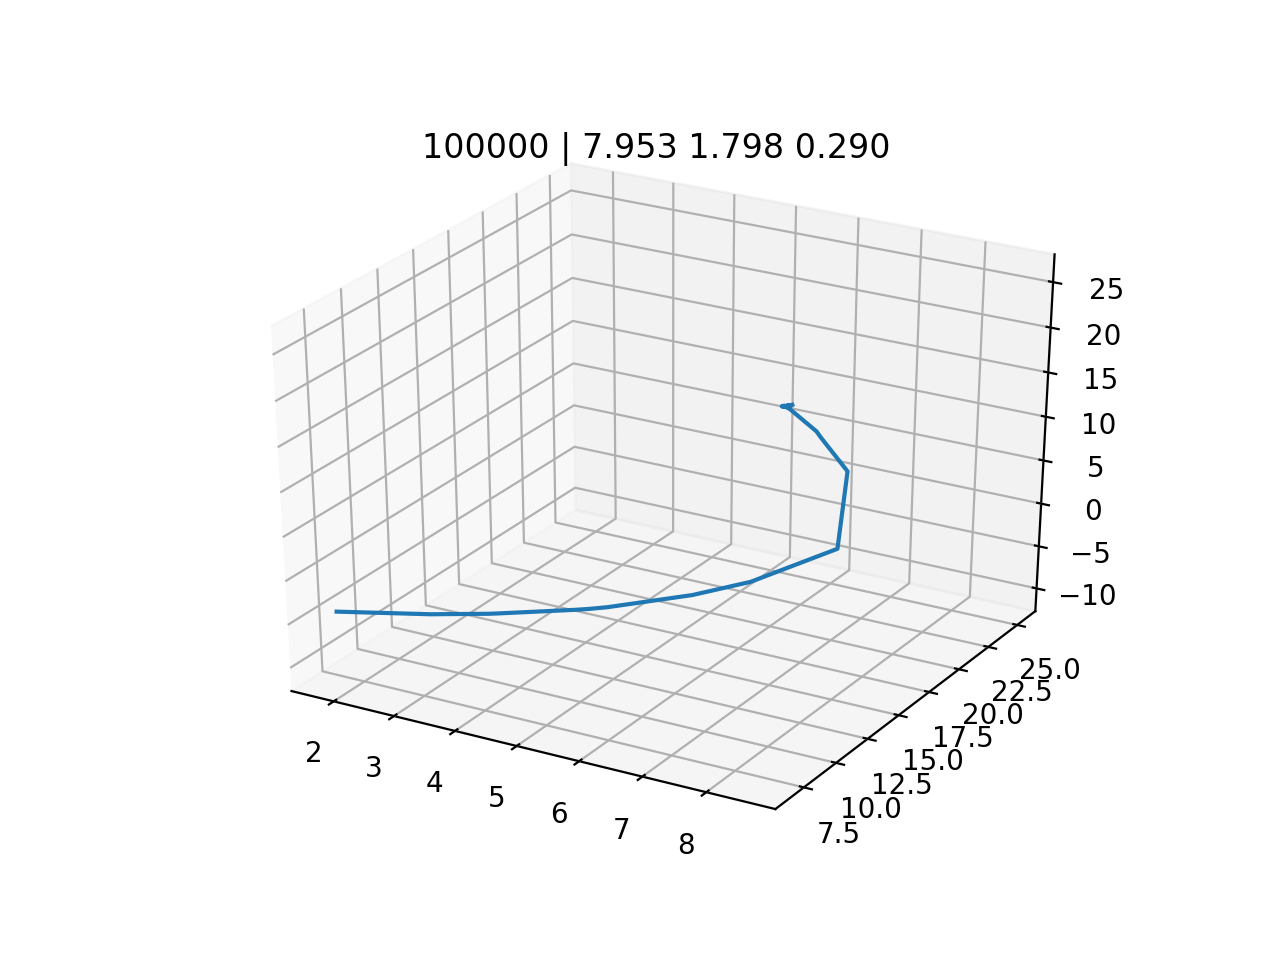

CPU times: user 10h 39min, sys: 44min 22s, total: 11h 23min 23s
Wall time: 10h 47min 13s


In [8]:
%%time
hidden_layers = []
for i in range(3):
    hidden_layers += [
        lambda x: tf.layers.dense(x, 300, activation=tf.nn.leaky_relu),
        lambda x: tf.layers.dropout(x),
    ]
test(T=40, ode_param=ODEParameter(10, 28, 8/3), boundary_target=[[1, 1, 1]],
     n_iters=10**5, hidden_layers=hidden_layers,
     optimizer=tf.train.AdamOptimizer(1e-3), lambda_=100)

* It seems that optimizer hints a local minimum which is too deep to escape. This local minimum is an attractor of the Lorentz system, i.e. at $(x, y, z) = 0$.

## Solving by Traditional Method